In [1]:
import scipy.io
import skimage.io
import mat73
import matplotlib.pyplot as plt
import skimage.transform
import numpy as np
import seaborn as sns
import glob
from IPython import display
import time
import os
import pandas as pd
import itertools
import scipy.stats


In [13]:
def rgb_to_hsv(img_rgb):
    height, width, channel=img_rgb.shape
    val_max=np.max(img_rgb, axis=2)
    val_min=np.min(img_rgb, axis=2)
    idx_val_max=np.argmax(img_rgb, axis=2)
    R=img_rgb[:,:,0]
    G=img_rgb[:,:,1]
    B=img_rgb[:,:,2]
    V=val_max
    df=val_max-val_min
    S=np.zeros_like(val_max)
    S[val_max==0]=0
    S[val_max!=0]=df[val_max!=0]/val_max[val_max!=0]
    H=np.zeros_like(val_max)
    idx0=val_max==val_min
    idx1=np.logical_and(idx_val_max==0, ~idx0)
    idx2=np.logical_and(idx_val_max==1, ~idx0)
    idx3=np.logical_and(idx_val_max==2, ~idx0)
    H[idx3]=((R[idx3]-G[idx3])/df[idx3]+4)%6
    H[idx2]=((B[idx2]-R[idx2])/df[idx2]+2)%6
    H[idx1]=((G[idx1]-B[idx1])/df[idx1]+6)%6
    H[idx0]=0
    return H,S,V
    
    

In [41]:
def draw_histograms(raw_file, img_file, meta_file):
    data=mat73.loadmat(raw_file)
    raw=data['x']
    ch00=raw[0::2, 0::2]
    ch01=raw[0::2, 1::2]
    ch10=raw[1::2, 0::2]
    ch11=raw[1::2, 1::2]
    
    img=skimage.io.imread(img_file)
    
    meta=scipy.io.loadmat(meta_file)
    
    keys=meta['metadata'][0,0].dtype.names
    vals=meta['metadata'][0,0]
    meta_data={k:v for k,v in zip(keys, vals)}
    WB=1/meta_data['AsShotNeutral'].reshape(-1)
    
    if ('GP' in raw_file) or ('N6' in raw_file) or ('G4' in raw_file):
        b=ch00*WB[2]
        g=ch01*WB[1]
        r=ch11*WB[0]
    elif 'IP' in raw_file:
        b=ch11*WB[2]
        g=ch01*WB[1]
        r=ch00*WB[0]
    elif 'S6' in raw_file:
        b=ch10*WB[2]
        g=ch00*WB[1]
        r=ch01*WB[0]
    b=np.clip(b, 0,1)
    g=np.clip(g, 0,1)
    r=np.clip(r, 0,1)
    raw_re=np.concatenate([r.reshape(r.shape+(1,)),
                       g.reshape(r.shape+(1,)),
                       b.reshape(r.shape+(1,))], axis=-1)
    
    img_re=skimage.transform.rescale(img, 0.5, order=3, multichannel=True)

    H_srgb,S_srgb,V_srgb=rgb_to_hsv(img_re)
    H_raw, S_raw, V_raw=rgb_to_hsv(raw_re)
    display.clear_output(wait=True)
    display.display(plt.gcf())   
    
    plt.figure(figsize=(16,16))
    plt.subplot(4,2,1); sns.histplot([H_srgb.reshape(-1), H_raw.reshape(-1)], bins=50);plt.legend(labels=['Raw','sRGB']);plt.title('H')
    plt.subplot(4,2,3); sns.histplot([S_srgb.reshape(-1), S_raw.reshape(-1)], bins=50);plt.legend(labels=['Raw','sRGB']);plt.title('S')
    plt.subplot(4,2,5); sns.histplot([V_srgb.reshape(-1), V_raw.reshape(-1)], bins=50);plt.legend(labels=['Raw','sRGB']);plt.title('V')
    #plt.subplot(3,2,2);plt.imshow(img_re); plt.title(os.path.basename(raw_file))
    plt.subplot(4,2,7);plt.imshow(raw_re); plt.title('_'.join(raw_file.split('\\')[1:]))#plt.title(os.path.basename(raw_file))
    plt.subplot(4,2,2); sns.scatterplot(x=H_srgb.flatten(), y=H_raw.flatten());plt.title('H')
    plt.subplot(4,2,4); sns.scatterplot(x=S_srgb.flatten(), y=S_raw.flatten());plt.title('S')
    plt.subplot(4,2,6); sns.scatterplot(x=V_srgb.flatten(), y=V_raw.flatten());plt.title('V')
    
    return

In [16]:
# raw_file_list=[glob.glob(el+'/GT_RAW_*.MAT')[0] for el in glob.glob('./SIDD_Small_Raw_Only/Data/*')]
# img_file_list=[glob.glob(el+'/GT_SRGB_*.PNG')[0] for el in glob.glob('./SIDD_Small_sRGB_Only/Data/*')]
# meta_file_list=[glob.glob(el+'/METADATA_RAW_*.MAT')[0] for el in glob.glob('./SIDD_Small_Raw_Only/Data/*')]

raw_file_list=[glob.glob(el+'/*GT_RAW_*.MAT') for el in glob.glob('/dataset/SIDD/SIDD_Medium_Raw/Data/*')]
raw_file_list=list(itertools.chain(*raw_file_list))
img_file_list=[glob.glob(el+'/*GT_SRGB_*.PNG') for el in glob.glob('/dataset/SIDD/SIDD_Medium_Srgb/Data/*')]
img_file_list=list(itertools.chain(*img_file_list))
meta_file_list=[glob.glob(el+'/*METADATA_RAW_*.MAT') for el in glob.glob('/dataset/SIDD/SIDD_Medium_Raw/Data/*')]
meta_file_list=list(itertools.chain(*meta_file_list))



<Figure size 1600x1600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

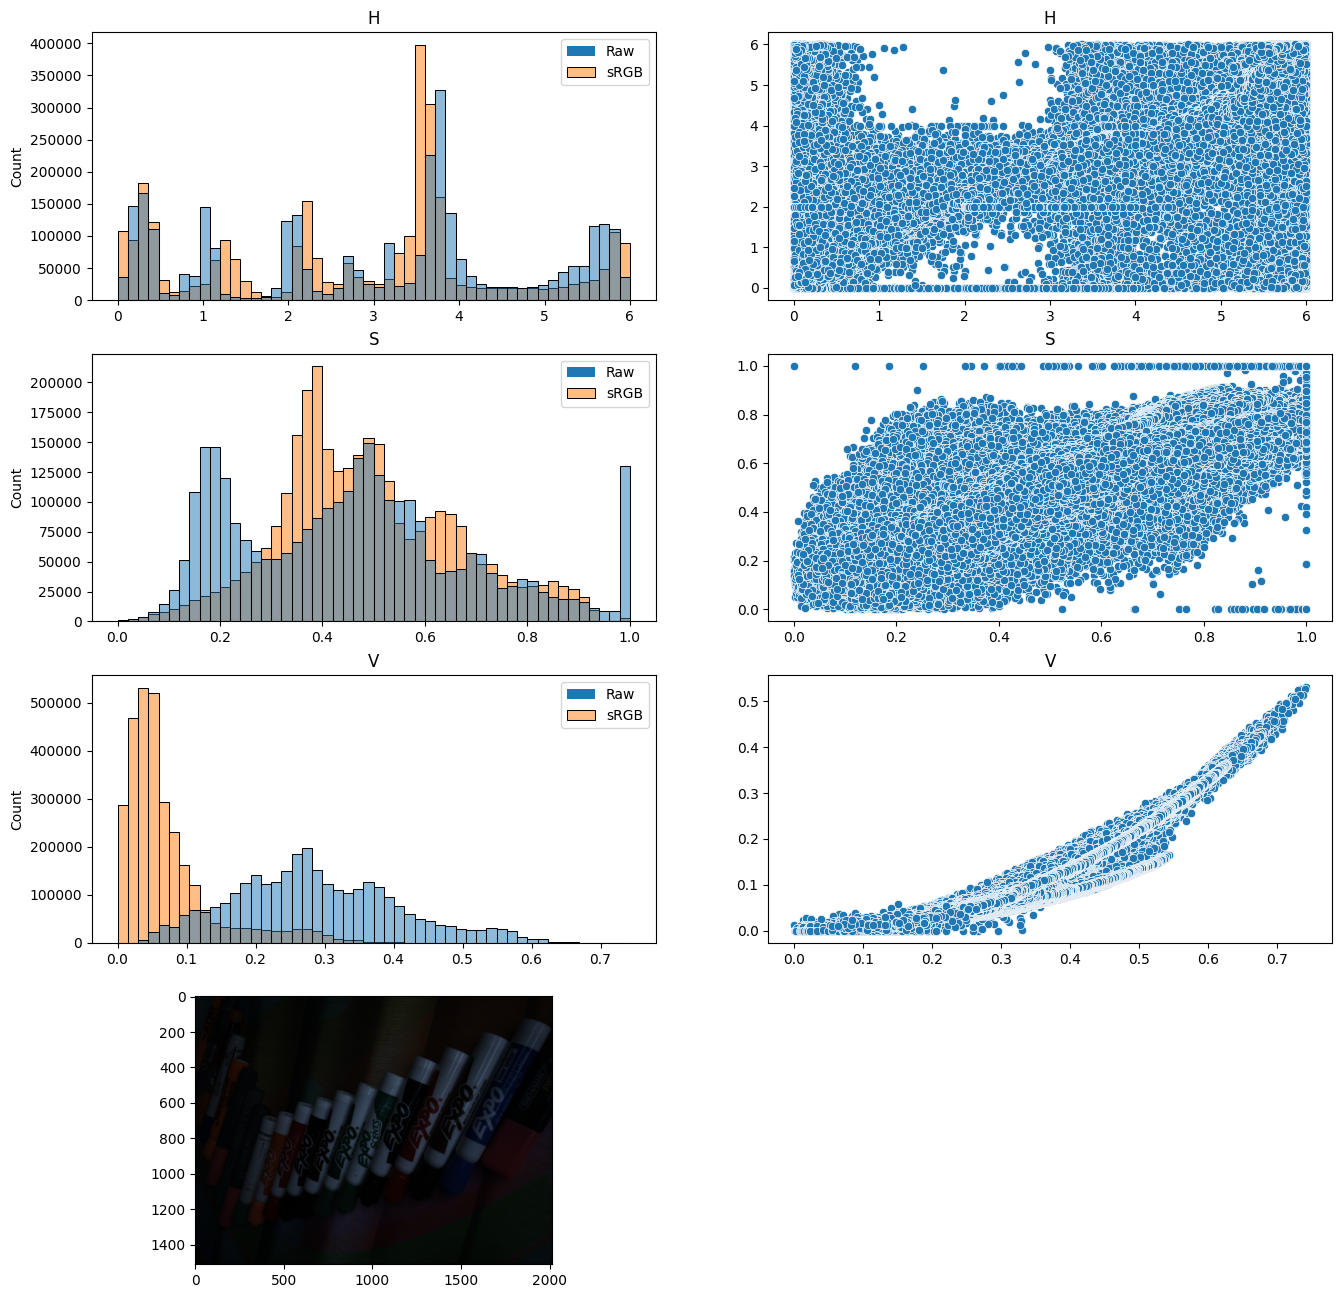

<Figure size 1600x1600 with 0 Axes>

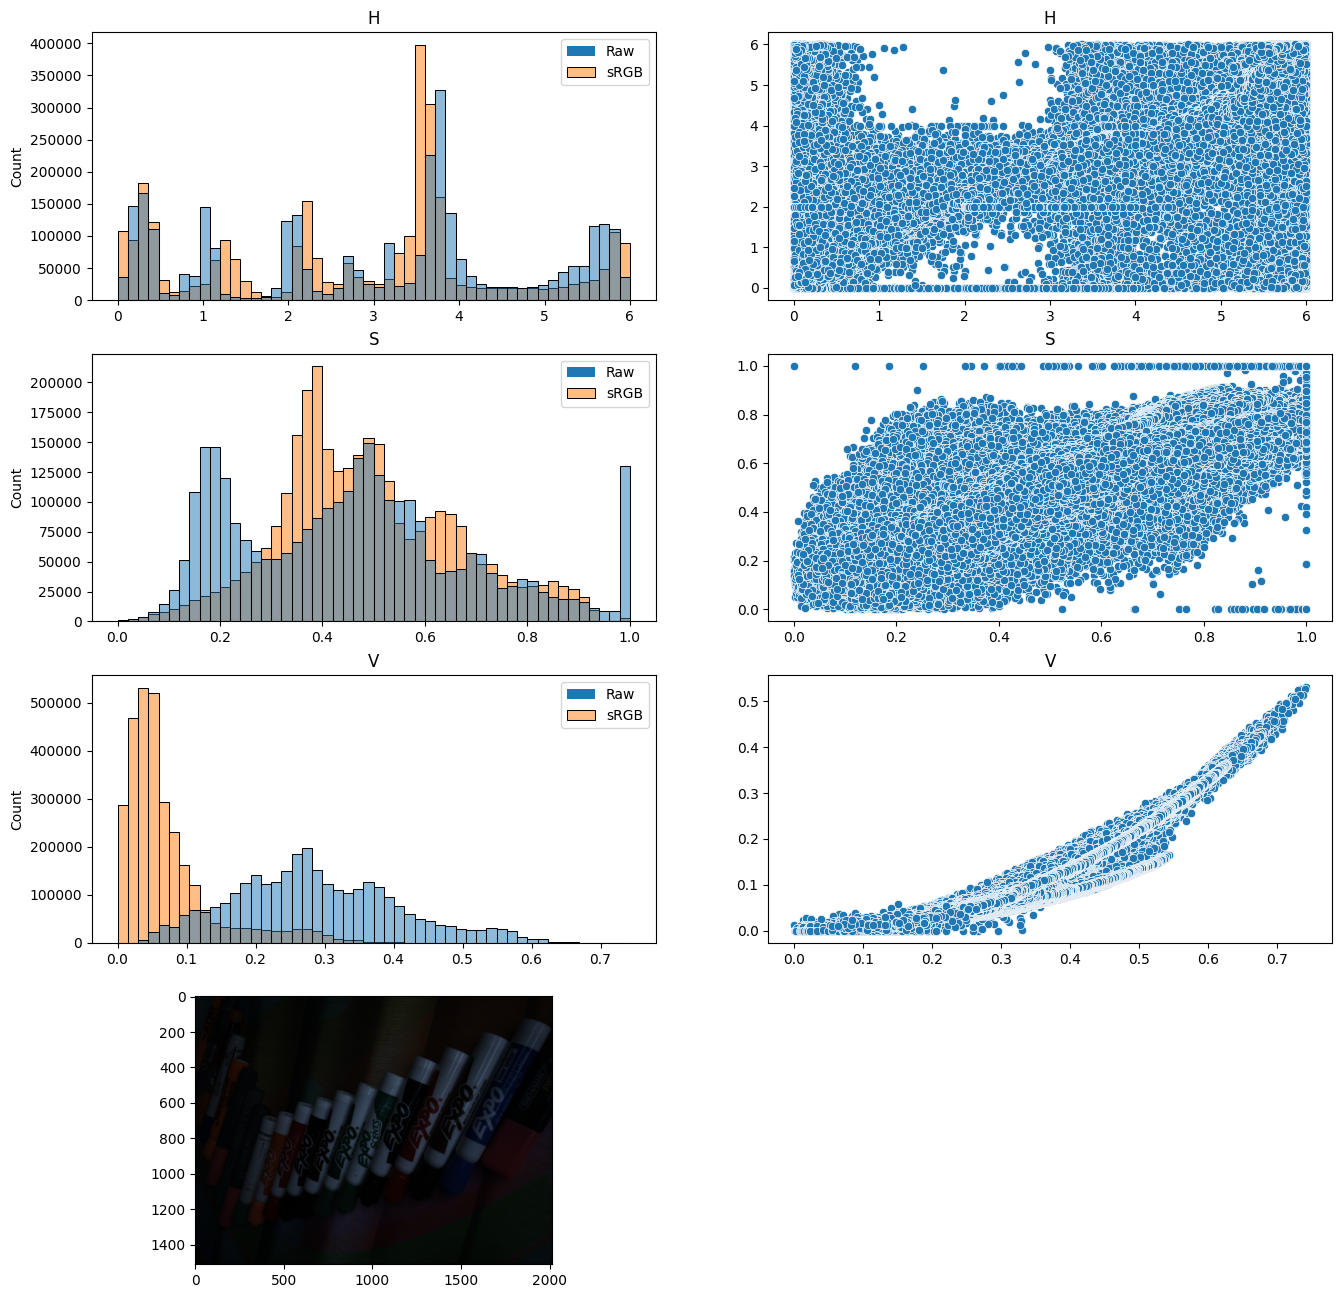

In [43]:
for raw_file, img_file, meta_file in zip(raw_file_list, img_file_list, meta_file_list):
    draw_histograms(raw_file, img_file, meta_file)
#     plt.figure(figsize=(16,16))
    plt.show()
#     input()
    break
    #time.sleep(1)

In [28]:
raw_file_list[0].split('/')[-2]

'0039_002_IP_00100_00180_5500_L'

In [25]:
df_raw=pd.DataFrame([el.split('/')[1].split('_') for el in raw_file_list])
df_raw.head()

,0
0,dataset
1,dataset
2,dataset
3,dataset
4,dataset


In [29]:
df_raw=pd.DataFrame([el.split('/')[-2].split('_') for el in raw_file_list],
                   columns=['scene_instance_number', 'scene_number', 'smartphone_code', 'ISO_level', 'shutter_speed', 'illuminant_temperature', 'illuminant_brightness_code'])
df_raw['raw_filepath']=raw_file_list
df_raw['img_filepath']=img_file_list
df_raw['meta_filepath']=meta_file_list
#df_raw

In [30]:
df_raw.shape

(320, 10)

<Figure size 640x480 with 0 Axes>

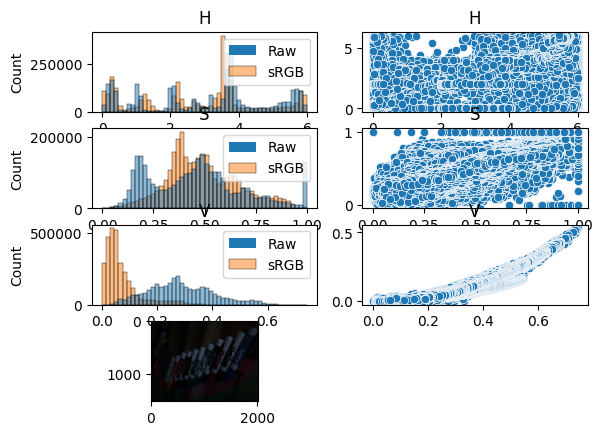

KeyboardInterrupt: 

In [31]:
smartphone_code='IP'
spec_raw_file_list=df_raw.groupby('smartphone_code').get_group(smartphone_code).iloc[:,-3].values
spec_img_file_list=df_raw.groupby('smartphone_code').get_group(smartphone_code).iloc[:,-2].values
spec_meta_file_list=df_raw.groupby('smartphone_code').get_group(smartphone_code).iloc[:,-1].values

# spec_raw_file_list=df_raw.groupby(['scene_number','smartphone_code']).get_group(('004','S6')).iloc[:,-3].values
# spec_img_file_list=df_raw.groupby(['scene_number','smartphone_code']).get_group(('004','S6')).iloc[:,-2].values
# spec_meta_file_list=df_raw.groupby(['scene_number','smartphone_code']).get_group(('004','S6')).iloc[:,-1].values

# spec_raw_file_list=df_raw.groupby(['illuminant_brightness_code','smartphone_code']).get_group(('L','S6')).iloc[:,-3].values
# spec_img_file_list=df_raw.groupby(['illuminant_brightness_code','smartphone_code']).get_group(('L','S6')).iloc[:,-2].values
# spec_meta_file_list=df_raw.groupby(['illuminant_brightness_code','smartphone_code']).get_group(('L','S6')).iloc[:,-1].values

for raw_file, img_file, meta_file in zip(spec_raw_file_list, spec_img_file_list, spec_meta_file_list):
    draw_histograms(raw_file, img_file, meta_file)
    plt.show()
    input()

In [34]:
#(df_raw.iloc[:,-3].apply(lambda x: x.split('\\')[1])==df_raw.iloc[:,-2].apply(lambda x: x.split('\\')[1])).sum()
#(df_raw.iloc[:,-3].apply(lambda x: x.split('\\')[-1].split('.')[-2].replace('RAW','DUM'))==df_raw.iloc[:,-2].apply(lambda x: x.split('\\')[-1].split('.')[-2].replace('SRGB','DUM'))).sum()
(df_raw.iloc[:,-3].apply(lambda x: x.split('\\')[-1].split('.')[-2].replace('GT','DUM'))==df_raw.iloc[:,-1].apply(lambda x: x.split('\\')[-1].split('.')[-2].replace('METADATA','DUM'))).sum()

168

In [36]:
raw_file=spec_raw_file_list[10]
img_file=spec_img_file_list[10]
meta_file=spec_meta_file_list[10]
if 1:
    data=mat73.loadmat(raw_file)
    raw=data['x']
    ch00=raw[0::2, 0::2]
    ch01=raw[0::2, 1::2]
    ch10=raw[1::2, 0::2]
    ch11=raw[1::2, 1::2]
    
    img=skimage.io.imread(img_file)
    
    meta=scipy.io.loadmat(meta_file)
    
    keys=meta['metadata'][0,0].dtype.names
    vals=meta['metadata'][0,0]
    meta_data={k:v for k,v in zip(keys, vals)}
    WB=1/meta_data['AsShotNeutral'].reshape(-1)
    
    if ('GP' in raw_file) or ('N6' in raw_file) or ('G4' in raw_file):
        b=ch00*WB[2]
        g=ch01*WB[1]
        r=ch11*WB[0]
    elif 'IP' in raw_file:
        b=ch11*WB[2]
        g=ch01*WB[1]
        r=ch00*WB[0]
    elif 'S6' in raw_file:
        b=ch10*WB[2]
        g=ch00*WB[1]
        r=ch01*WB[0]
    b=np.clip(b, 0,1)
    g=np.clip(g, 0,1)
    r=np.clip(r, 0,1)
    raw_re=np.concatenate([r.reshape(r.shape+(1,)),
                       g.reshape(r.shape+(1,)),
                       b.reshape(r.shape+(1,))], axis=-1)
    
    img_re=skimage.transform.rescale(img, 0.5, order=3, multichannel=True)

    H_srgb,S_srgb,V_srgb=rgb_to_hsv(img_re)
    H_raw, S_raw, V_raw=rgb_to_hsv(raw_re)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(12, 12)) 
    plt.subplot(3,2,1); sns.histplot([H_srgb.reshape(-1), H_raw.reshape(-1)], bins=50);plt.legend(labels=['Raw','sRGB',])
    plt.subplot(3,2,3); sns.histplot([S_srgb.reshape(-1), S_raw.reshape(-1)], bins=50);plt.legend(labels=['Raw','sRGB'])
    plt.subplot(3,2,5); sns.histplot([V_srgb.reshape(-1), V_raw.reshape(-1)], bins=50);plt.legend(labels=['Raw','sRGB'])
    #plt.subplot(3,2,2);plt.imshow(img_re); plt.title(os.path.basename(raw_file))
    plt.subplot(3,2,2);plt.imshow(raw_re); plt.title('_'.join(raw_file.split('\\')[1:]))#plt.title(os.path.basename(raw_file))

<Figure size 640x480 with 0 Axes>

In [37]:
#scipy.stats.ks_2samp(np.random.randn(*V_raw.reshape(-1).shape), np.random.randn(*V_raw.reshape(-1).shape))
idx=np.random.rand(*S_raw.reshape(-1).shape)<1.1
print(np.sum(idx))
print(scipy.stats.ks_2samp(H_raw.reshape(-1)[idx], H_srgb.reshape(-1)[idx], mode='auto'))
print(scipy.stats.ks_2samp(S_raw.reshape(-1)[idx], S_srgb.reshape(-1)[idx], mode='auto'))
print(scipy.stats.ks_2samp(V_raw.reshape(-1)[idx], V_srgb.reshape(-1)[idx], mode='auto'))

#?scipy.stats.ks_2samp
#S_raw.reshape(-1).shape

3048192
KstestResult(statistic=0.2983916367472916, pvalue=0.0)
KstestResult(statistic=0.16818035084404137, pvalue=0.0)
KstestResult(statistic=0.6471583810993533, pvalue=0.0)


In [130]:
print("\n".join(spec_raw_file_list))

./SIDD_Medium_Raw/Data\0028_001_IP_00100_00160_5500_N\0028_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0028_001_IP_00100_00160_5500_N\0028_GT_RAW_011.MAT
./SIDD_Medium_Raw/Data\0029_001_IP_00800_01000_5500_N\0029_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0029_001_IP_00800_01000_5500_N\0029_GT_RAW_011.MAT
./SIDD_Medium_Raw/Data\0030_001_IP_01600_02000_5500_N\0030_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0030_001_IP_01600_02000_5500_N\0030_GT_RAW_011.MAT
./SIDD_Medium_Raw/Data\0032_001_IP_00800_01000_3200_N\0032_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0032_001_IP_00800_01000_3200_N\0032_GT_RAW_011.MAT
./SIDD_Medium_Raw/Data\0033_001_IP_00100_00160_3200_N\0033_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0033_001_IP_00100_00160_3200_N\0033_GT_RAW_011.MAT
./SIDD_Medium_Raw/Data\0039_002_IP_00100_00180_5500_L\0039_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0039_002_IP_00100_00180_5500_L\0039_GT_RAW_011.MAT
./SIDD_Medium_Raw/Data\0040_002_IP_00800_02000_5500_L\0040_GT_RAW_010.MAT
./SIDD_Medium_Raw/Data\0040_002_IP_008

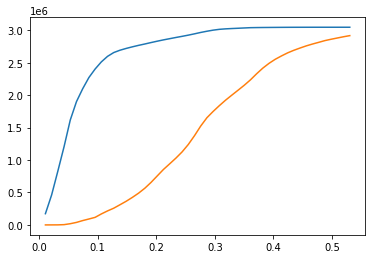

In [158]:
cnt, x=np.histogram(V_raw.reshape(-1), bins=x)
cnt2, x=np.histogram(V_srgb.reshape(-1),bins=x)
plt.plot(x[1:], np.cumsum(cnt))
plt.plot(x[1:],np.cumsum(cnt2))

In [191]:
df_raw.groupby('scene_number').get_group('008')

,scene_instance_number,scene_number,smartphone_code,ISO_level,shutter_speed,illuminant_temperature,illuminant_brightness_code,raw_filepath,img_filepath,meta_filepath
262,0167,008,N6,00100,00050,4400,L,./SIDD_Medium_Raw/Data\0167_008_N6_00100_00050...,./SIDD_Medium_Srgb/Data\0167_008_N6_00100_0005...,./SIDD_Medium_Raw/Data\0167_008_N6_00100_00050...
263,0167,008,N6,00100,00050,4400,L,./SIDD_Medium_Raw/Data\0167_008_N6_00100_00050...,./SIDD_Medium_Srgb/Data\0167_008_N6_00100_0005...,./SIDD_Medium_Raw/Data\0167_008_N6_00100_00050...
264,0168,008,N6,00400,00200,4400,L,./SIDD_Medium_Raw/Data\0168_008_N6_00400_00200...,./SIDD_Medium_Srgb/Data\0168_008_N6_00400_0020...,./SIDD_Medium_Raw/Data\0168_008_N6_00400_00200...
265,0168,008,N6,00400,00200,4400,L,./SIDD_Medium_Raw/Data\0168_008_N6_00400_00200...,./SIDD_Medium_Srgb/Data\0168_008_N6_00400_0020...,./SIDD_Medium_Raw/Data\0168_008_N6_00400_00200...
266,0169,008,N6,00800,00400,4400,L,./SIDD_Medium_Raw/Data\0169_008_N6_00800_00400...,./SIDD_Medium_Srgb/Data\0169_008_N6_00800_0040...,./SIDD_Medium_Raw/Data\0169_008_N6_00800_00400...
267,0169,008,N6,00800,00400,4400,L,./SIDD_Medium_Raw/Data\0169_008_N6_00800_00400...,./SIDD_Medium_Srgb/Data\0169_008_N6_00800_0040...,./SIDD_Medium_Raw/Data\0169_008_N6_00800_00400...
268,0170,008,N6,01600,00800,4400,L,./SIDD_Medium_Raw/Data\0170_008_N6_01600_00800...,./SIDD_Medium_Srgb/Data\0170_008_N6_01600_0080...,./SIDD_Medium_Raw/Data\0170_008_N6_01600_00800...
269,0170,008,N6,01600,00800,4400,L,./SIDD_Medium_Raw/Data\0170_008_N6_01600_00800...,./SIDD_Medium_Srgb/Data\0170_008_N6_01600_0080...,./SIDD_Medium_Raw/Data\0170_008_N6_01600_00800...
270,0172,008,G4,00100,00100,4400,N,./SIDD_Medium_Raw/Data\0172_008_G4_00100_00100...,./SIDD_Medium_Srgb/Data\0172_008_G4_00100_0010...,./SIDD_Medium_Raw/Data\0172_008_G4_00100_00100...
271,0172,008,G4,00100,00100,4400,N,./SIDD_Medium_Raw/Data\0172_008_G4_00100_00100...,./SIDD_Medium_Srgb/Data\0172_008_G4_00100_0010...,./SIDD_Medium_Raw/Data\0172_008_G4_00100_00100...


In [188]:
df_raw.query('smartphone_code=="IP"').iloc[:,:-3].value_counts('scene_number').sort_index()

scene_number
001    10
002    10
003    10
004    10
005    14
006    14
007    14
008    14
009    12
dtype: int64

In [192]:
df_raw.groupby('smartphone_code').get_group(smartphone_code).iloc[:,-2].values[30:]

array(['./SIDD_Medium_Srgb/Data\\0088_004_IP_00100_00050_5500_N\\0088_GT_SRGB_010.PNG',
       './SIDD_Medium_Srgb/Data\\0088_004_IP_00100_00050_5500_N\\0088_GT_SRGB_011.PNG',
       './SIDD_Medium_Srgb/Data\\0089_004_IP_00500_00250_5500_N\\0089_GT_SRGB_010.PNG',
       './SIDD_Medium_Srgb/Data\\0089_004_IP_00500_00250_5500_N\\0089_GT_SRGB_011.PNG',
       './SIDD_Medium_Srgb/Data\\0090_004_IP_01600_00750_5500_N\\0090_GT_SRGB_010.PNG',
       './SIDD_Medium_Srgb/Data\\0090_004_IP_01600_00750_5500_N\\0090_GT_SRGB_011.PNG',
       './SIDD_Medium_Srgb/Data\\0091_004_IP_00320_00080_3200_L\\0091_GT_SRGB_010.PNG',
       './SIDD_Medium_Srgb/Data\\0091_004_IP_00320_00080_3200_L\\0091_GT_SRGB_011.PNG',
       './SIDD_Medium_Srgb/Data\\0092_004_IP_00640_00125_3200_L\\0092_GT_SRGB_010.PNG',
       './SIDD_Medium_Srgb/Data\\0092_004_IP_00640_00125_3200_L\\0092_GT_SRGB_011.PNG',
       './SIDD_Medium_Srgb/Data\\0110_005_IP_00100_00100_5500_L\\0110_GT_SRGB_010.PNG',
       './SIDD_Medium_Srgb/Data\

In [11]:
H_srgb.shape

(1500, 2664)

In [12]:
H_raw.shape

(1500, 2664)

In [17]:
scipy.stats.wilcoxon(V_srgb.flatten(), V_raw.flatten())

WilcoxonResult(statistic=0.0, pvalue=0.0)

In [20]:
print(scipy.stats.spearmanr(H_srgb.flatten(), H_raw.flatten()))
print(scipy.stats.spearmanr(S_srgb.flatten(), S_raw.flatten()))
print(scipy.stats.spearmanr(V_srgb.flatten(), V_raw.flatten()))

SpearmanrResult(correlation=0.5422815326631613, pvalue=0.0)
SpearmanrResult(correlation=0.888498593436021, pvalue=0.0)
SpearmanrResult(correlation=0.9849806543885009, pvalue=0.0)


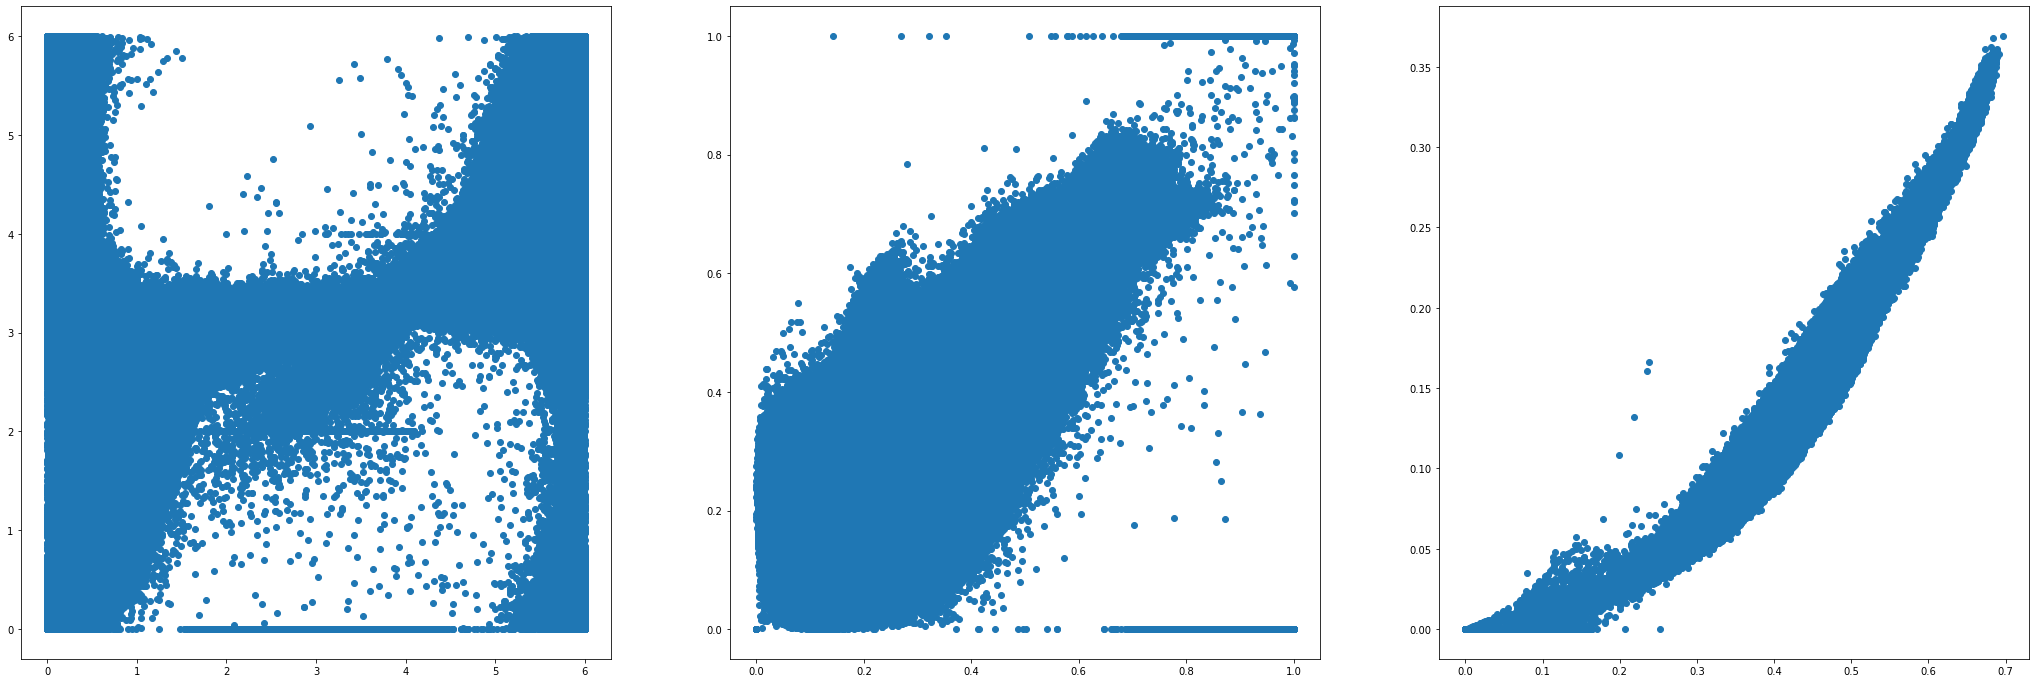

In [24]:
fig, ax=plt.subplots(1,3, figsize=(12*3,12))
ax[0].scatter(x=H_srgb.flatten(), y=H_raw.flatten())
ax[1].scatter(x=S_srgb.flatten(), y=S_raw.flatten())
ax[2].scatter(x=V_srgb.flatten(), y=V_raw.flatten())